In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy import signal
import json
from scipy.signal import butter, sosfiltfilt


--- Loading Philip_LP4_breathing_b_hard_2025-11-05_1219.csv ---
DEBUG: Raw DataFrame shape: (5500, 56)
DEBUG: Found 52 subcarrier columns.
DEBUG: Sample complex value (Sub 0, Row 0): (-10+9j)
DEBUG: Calculated Sampling Rate (Fs): 137.73 Hz
DEBUG: Total Duration: 39.93 seconds

--- Loading Philip_LP4_no_breathing_nb_no_presence_2025-11-05_1223.csv ---
DEBUG: Raw DataFrame shape: (5500, 56)
DEBUG: Found 52 subcarrier columns.
DEBUG: Sample complex value (Sub 0, Row 0): (15-5j)
DEBUG: Calculated Sampling Rate (Fs): 137.58 Hz
DEBUG: Total Duration: 39.97 seconds

--- Data Loading Complete ---
DEBUG: Amp Breath Matrix Shape: (5500, 52)
DEBUG: Amp No-Breath Matrix Shape: (5500, 52)

--- Generating Heatmaps ---


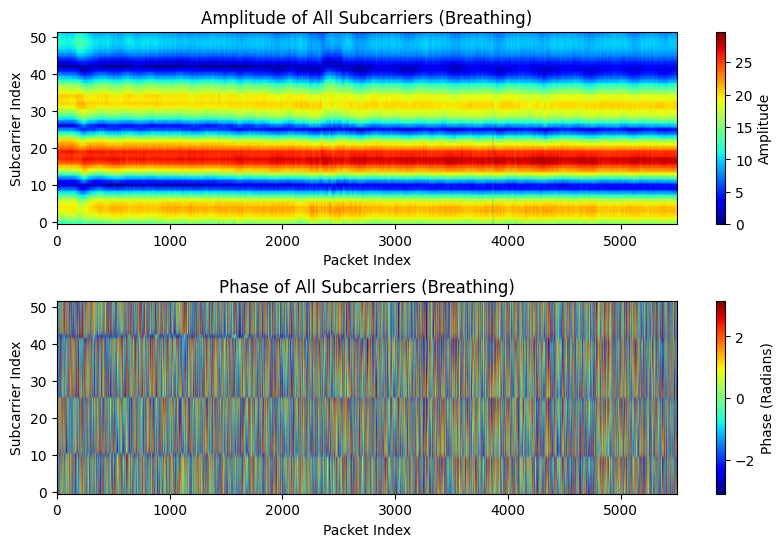


--- Comparing Breathing vs No Breathing (Subcarrier 15) ---
DEBUG: Breath Signal Stats -> Min: 13.04, Max: 26.57, Mean: 23.52
DEBUG: No-Breath Signal Stats -> Min: 20.00, Max: 23.60, Mean: 21.76


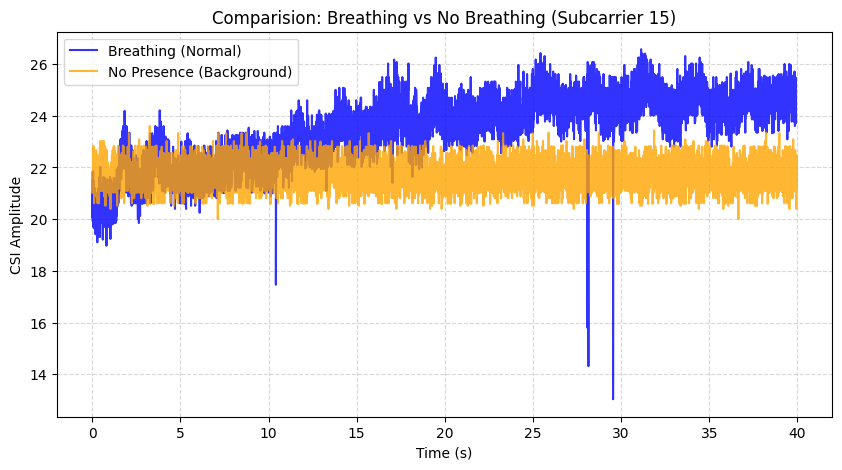


--- Running Frequency Analysis (FFT) ---
DEBUG: Detrended signal mean (should be ~0): 0.00000
DEBUG: Peak Frequency in FFT: 0.0250 Hz (1.50 BPM)


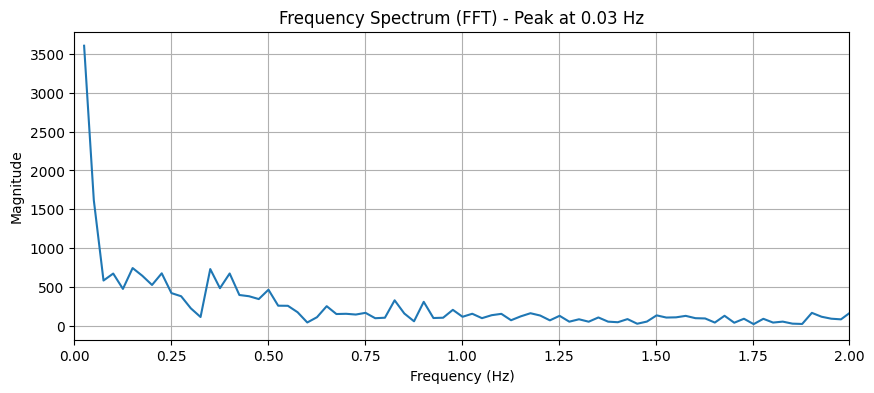


--- Starting Filter Pipeline ---
DEBUG: Nyquist Freq: 68.86 Hz
DEBUG: Filter Normalized Freqs -> Low: 0.00145, High: 0.00726
DEBUG: Removing Outliers...
DEBUG: Found 10 outliers out of 5500 points.
DEBUG: NaNs filled.
DEBUG: Applying SOS Filter...
DEBUG: Filtered Signal Stats -> Min: -0.84116, Max: 0.66826


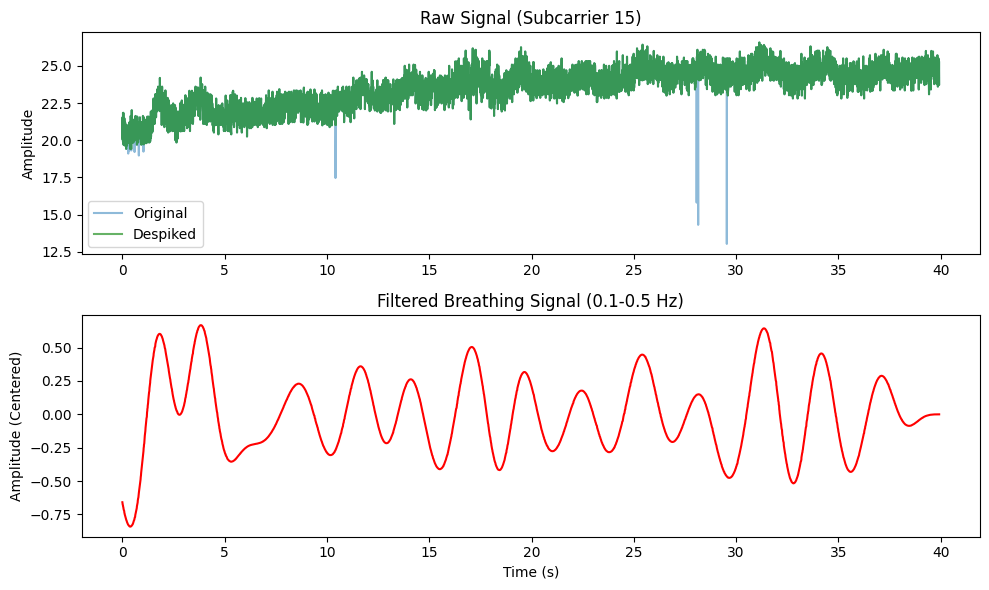


--- Pipeline Finished ---


In [ ]:
def load_csi_data(csv_file):
    print(f"\n--- Loading {csv_file} ---")
    
    # 1. Load CSV
    df = pd.read_csv(csv_file)
    print(f"DEBUG: Raw DataFrame shape: {df.shape}")
    
    # 2. Convert 'sub_' columns to complex numbers
    sub_cols = [c for c in df.columns if 'sub_' in c]
    print(f"DEBUG: Found {len(sub_cols)} subcarrier columns.")
    
    for col in sub_cols:
        df[col] = df[col].apply(lambda x: complex(str(x).replace('i', 'j')))
    
    # Check first value to ensure conversion worked
    print(f"DEBUG: Sample complex value (Sub 0, Row 0): {df[sub_cols[0]].iloc[0]}")
    
    # 3. Extract Matrices
    csi_matrix = df[sub_cols].values
    timestamps = df['timestamp'].values
    
    # 4. Calculate Sampling Rate (fs) dynamically
    time_diffs = np.diff(timestamps)
    avg_diff_seconds = np.mean(time_diffs) / 1_000_000
    fs = 1 / avg_diff_seconds
    
    print(f"DEBUG: Calculated Sampling Rate (Fs): {fs:.2f} Hz")
    print(f"DEBUG: Total Duration: {(timestamps[-1] - timestamps[0])/1_000_000:.2f} seconds")
    
    return np.abs(csi_matrix), np.angle(csi_matrix), timestamps, fs

# ==========================================
# PART 1: Load Both Datasets
# ==========================================
# Load your breathing data
amp_breath, pha_breath, time_breath, fs_breath = load_csi_data('Philip_LP4_no_breathing_nb_holding_2025-11-05_1222.csv')

# Load the "No Breathing" background data
amp_nobreath, pha_nobreath, time_nobreath, fs_nobreath = load_csi_data('Philip_LP4_no_breathing_nb_no_presence_2025-11-05_1223.csv')

print("\n--- Data Loading Complete ---")
print(f"DEBUG: Amp Breath Matrix Shape: {amp_breath.shape}")
print(f"DEBUG: Amp No-Breath Matrix Shape: {amp_nobreath.shape}")

# ==========================================
# PART 2: Heatmap Visualization
# ==========================================
print("\n--- Generating Heatmaps ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), dpi=100)
plt.subplots_adjust(hspace=0.4)

im1 = ax1.imshow(amp_breath.T, aspect='auto', cmap='jet', origin='lower')
ax1.set_title('Amplitude of All Subcarriers (Breathing)')
ax1.set_xlabel('Packet Index')
ax1.set_ylabel('Subcarrier Index')
fig.colorbar(im1, ax=ax1, label='Amplitude')

im2 = ax2.imshow(pha_breath.T, aspect='auto', cmap='jet', origin='lower')
ax2.set_title('Phase of All Subcarriers (Breathing)')
ax2.set_xlabel('Packet Index')
ax2.set_ylabel('Subcarrier Index')
fig.colorbar(im2, ax=ax2, label='Phase (Radians)')

plt.show()

# ==========================================
# PART 3: Breathing vs. No Breathing Comparison
# ==========================================
sel_sub = 15
print(f"\n--- Comparing Breathing vs No Breathing (Subcarrier {sel_sub}) ---")

# Normalize time axes
t_axis_breath = (time_breath - time_breath[0]) / 1_000_000
t_axis_nobreath = (time_nobreath - time_nobreath[0]) / 1_000_000

# Check stats of the selected subcarrier
print(f"DEBUG: Breath Signal Stats -> Min: {np.min(amp_breath[:, sel_sub]):.2f}, Max: {np.max(amp_breath[:, sel_sub]):.2f}, Mean: {np.mean(amp_breath[:, sel_sub]):.2f}")
print(f"DEBUG: No-Breath Signal Stats -> Min: {np.min(amp_nobreath[:, sel_sub]):.2f}, Max: {np.max(amp_nobreath[:, sel_sub]):.2f}, Mean: {np.mean(amp_nobreath[:, sel_sub]):.2f}")

plt.figure(figsize=(10, 5), dpi=100)
plt.title(f'Comparision: Breathing vs No Breathing (Subcarrier {sel_sub})')
plt.plot(t_axis_breath, amp_breath[:, sel_sub], label='Breathing (Normal)', color='blue', alpha=0.8)
plt.plot(t_axis_nobreath, amp_nobreath[:, sel_sub], label='No Presence (Background)', color='orange', alpha=0.8)
plt.xlabel('Time (s)')
plt.ylabel('CSI Amplitude')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ==========================================
# PART 4: Frequency Analysis (FFT)
# ==========================================
print("\n--- Running Frequency Analysis (FFT) ---")
signal_data = amp_breath[:, sel_sub]

# Remove DC Component
signal_detrend = signal_data - np.mean(signal_data)
print(f"DEBUG: Detrended signal mean (should be ~0): {np.mean(signal_detrend):.5f}")

# Perform FFT
N = len(signal_detrend)
fft_vals = fft(signal_detrend)
freqs = np.fft.fftfreq(N, d=1/fs_breath)

# Keep only positive frequencies
pos_mask = freqs > 0
freqs_pos = freqs[pos_mask]
fft_pos = np.abs(fft_vals)[pos_mask]

# Find Peak Frequency
peak_idx = np.argmax(fft_pos)
peak_freq = freqs_pos[peak_idx]
print(f"DEBUG: Peak Frequency in FFT: {peak_freq:.4f} Hz ({peak_freq*60:.2f} BPM)")

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(freqs_pos, fft_pos)
plt.title(f'Frequency Spectrum (FFT) - Peak at {peak_freq:.2f} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2)
plt.grid(True)
plt.show()

# ==========================================
# PART 5: FIXED Pipeline (Stable Filter)
# ==========================================
print("\n--- Starting Filter Pipeline ---")

# 1. Settings
low_cut = 0.1
high_cut = 0.5
order = 4 

# Recalculate Nyquist
nyq = 0.5 * fs_breath 
low = low_cut / nyq
high = high_cut / nyq

print(f"DEBUG: Nyquist Freq: {nyq:.2f} Hz")
print(f"DEBUG: Filter Normalized Freqs -> Low: {low:.5f}, High: {high:.5f}")

if low <= 0 or high >= 1:
    print("CRITICAL WARNING: Filter frequencies are out of bounds (0 to 1). Check sampling rate!")

# 2. Outlier Removal
print("DEBUG: Removing Outliers...")
signal_data = amp_breath[:, sel_sub].copy()  
window_size = 10
rolling_median = pd.Series(signal_data).rolling(window=window_size, center=True).median()

threshold = 3 * np.std(signal_data)
mean_val = np.mean(signal_data)
outliers = np.abs(signal_data - mean_val) > threshold
print(f"DEBUG: Found {np.sum(outliers)} outliers out of {len(signal_data)} points.")

signal_data[outliers] = rolling_median[outliers]

# FIX: Modern Pandas Syntax
signal_data = pd.Series(signal_data).bfill().ffill().values
print("DEBUG: NaNs filled.")

# 3. Stable Filter (SOS)
print("DEBUG: Applying SOS Filter...")
sos = butter(order, [low, high], btype='band', output='sos')
filtered_amp = sosfiltfilt(sos, signal_data)

print(f"DEBUG: Filtered Signal Stats -> Min: {np.min(filtered_amp):.5f}, Max: {np.max(filtered_amp):.5f}")

# 4. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), dpi=100)

ax1.plot(t_axis_breath, amp_breath[:, sel_sub], label='Original', alpha=0.5)
ax1.plot(t_axis_breath, signal_data, label='Despiked', color='green', alpha=0.6)
ax1.set_title(f'Raw Signal (Subcarrier {sel_sub})')
ax1.set_ylabel('Amplitude')
ax1.legend()

ax2.plot(t_axis_breath, filtered_amp, 'r')
ax2.set_title(f'Filtered Breathing Signal ({low_cut}-{high_cut} Hz)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (Centered)')

plt.tight_layout()
plt.show()
print("\n--- Pipeline Finished ---")

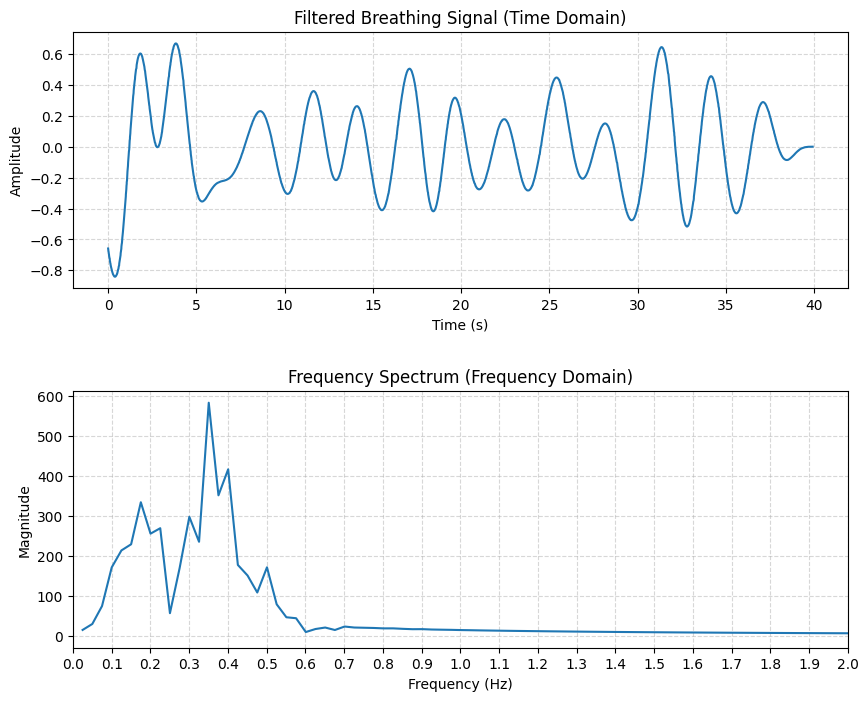


------------------------------------------------
Peak Frequency found at: 0.3506 Hz
ESTIMATED BREATHING RATE: 21.03 BPM
------------------------------------------------
Manual Observation: 20.0 BPM
Model Prediction:   21.03 BPM
Squared Error:      1.0709


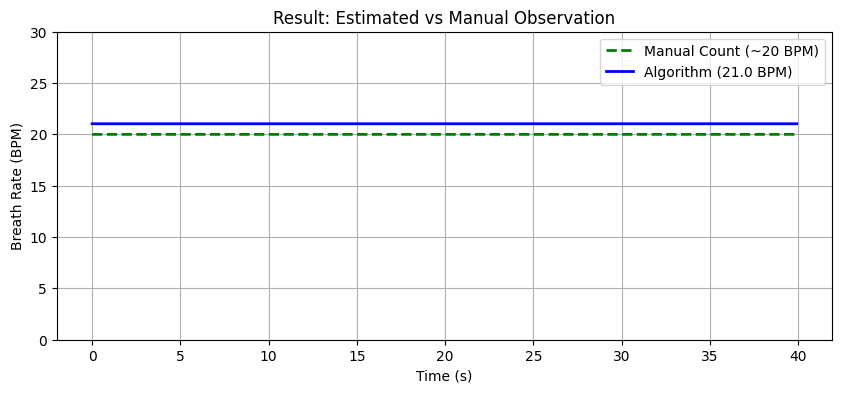

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.fft import fft, fftfreq

# ==========================================
# PART 6: FFT & Peak Detection
# ==========================================

# --- 1. Perform FFT on the Filtered Signal ---
# We use the 'filtered_amp' from Part 5
N = len(filtered_amp)
extracted_CSI = fft(filtered_amp)

# Calculate the correct Frequency Axis based on YOUR sampling rate
# The tutorial used np.linspace(0, 50...), which assumes fs=100. 
# We use fftfreq to be exact.
freqs = fftfreq(N, d=1/fs_breath) 

# Keep only positive frequencies for analysis
pos_mask = freqs > 0
freqs_pos = freqs[pos_mask]
fft_pos = np.abs(extracted_CSI)[pos_mask]


# --- 2. Visualization (Time vs Frequency) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=100)
plt.subplots_adjust(hspace=0.4)

# Plot 1: The Filtered Time Signal
ax1.plot(t_axis_breath, filtered_amp)
ax1.set_title('Filtered Breathing Signal (Time Domain)')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Time (s)')
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot 2: The FFT Spectrum
ax2.plot(freqs_pos, fft_pos)
ax2.set_title('Frequency Spectrum (Frequency Domain)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude')
ax2.set_xlim(0, 2) # Focus on 0-2 Hz range
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1)) # Ticks every 0.1 Hz
ax2.grid(True, linestyle='--', alpha=0.5)

plt.show()


# --- 3. Peak Detection (Estimating BPM) ---
# We look for the highest peak strictly within the breathing range (0.1 - 0.5 Hz)
# This prevents selecting 0Hz (DC offset) or noise.
min_freq = 0.1
max_freq = 0.8 # Slightly wider to catch fast breathing

# Create a mask for the valid range
valid_range_mask = (freqs_pos >= min_freq) & (freqs_pos <= max_freq)

# Find the index of the max value strictly within that range
# We slice the array, find the argmax, then map it back to the frequency
target_freqs = freqs_pos[valid_range_mask]
target_amps = fft_pos[valid_range_mask]

peak_idx = np.argmax(target_amps)
estimated_freq = target_freqs[peak_idx]
estimated_bpm = estimated_freq * 60

print(f"\n------------------------------------------------")
print(f"Peak Frequency found at: {estimated_freq:.4f} Hz")
print(f"ESTIMATED BREATHING RATE: {estimated_bpm:.2f} BPM")
print(f"------------------------------------------------")


# --- 4. Evaluation (Comparing to Manual Count) ---
# Since we don't have a Ground Truth file, we assume the Manual Count 
# we observed in the previous step (~20 BPM) is the 'Truth'.

manual_ground_truth = 20.0 # From visual inspection
mse = (estimated_bpm - manual_ground_truth)**2

print(f"Manual Observation: {manual_ground_truth} BPM")
print(f"Model Prediction:   {estimated_bpm:.2f} BPM")
print(f"Squared Error:      {mse:.4f}")

# Visualizing the Result as a constant line
plt.figure(figsize=(10, 4), dpi=100)
plt.title(f'Result: Estimated vs Manual Observation')
plt.plot(t_axis_breath, [manual_ground_truth]*len(t_axis_breath), 'g--', label='Manual Count (~20 BPM)', linewidth=2)
plt.plot(t_axis_breath, [estimated_bpm]*len(t_axis_breath), 'b-', label=f'Algorithm ({estimated_bpm:.1f} BPM)', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Breath Rate (BPM)')
plt.ylim(0, 30)
plt.legend()
plt.grid(True)
plt.show()